# Practical — Introduction to GANs (DCGAN in PyTorch)

**Course:** Advanced Topics in Deep Learning  
**Topic:** Generative Adversarial Networks (GANs)  
**Author:** João Cordeiro (© 2025) — Educational use only.

---

## Context and Goals

This notebook is a practical complement to the lectures on Generative Adversarial Networks (GANs).  
Here you will move from theory to practice by implementing and training a GAN on a simple image dataset (for instance MNIST).

We will:

- Build a Deep Convolutional GAN (DCGAN) with a Generator and a Discriminator.  
- Train both networks in an adversarial loop and visualize how random noise turns into synthetic images.  
- Experiment with loss functions and training tricks to stabilize GAN training.  
- Diagnose common problems such as mode collapse or overpowered discriminator.  
- (Optional) Explore Wasserstein GAN with Gradient Penalty (WGAN-GP) and a simple Conditional GAN (cGAN).  
- Reflect on evaluation challenges and ethical implications of generative models.

By the end, you should understand not only how to implement a GAN, but also why training is unstable and what best practices researchers use to make GANs work in practice.
<br><br><br>
**Note:** GPU is optional (CPU works with fewer epochs).
If you are using CPU its a good option to reduce epochs and batch size to keep runtime reasonable.




## Learning Objectives
By the end of this practical, you should be able to:
- Explain the adversarial dynamics between Generator (G) and Discriminator (D).
- Implement a stable DCGAN architecture for simple images (MNIST).
- Train a GAN and monitor losses and generated samples over epochs.
- Diagnose common failures (e.g., mode collapse, discriminator overpowering).
- Discuss limitations of evaluation metrics (IS/FID) and ethical implications of generative models.


## Import Libraries

In [ ]:
import os, sys, random, time
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt


from pathlib import Path

# libraries fror getting the dataset and pre-processing methods
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

## Setup

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED) # to assure reproducibility on numpy (affects functions like np.random.rand, np.random.shuffle, etc.)
torch.manual_seed(SEED)  # to assure reproducibility on Torch (affects weight initialization, dropout, data shuffling, etc.)
torch.cuda.manual_seed_all(SEED) # usefull when using more than one GPT, otherwise torch.manual_seed is enough

# Ensure deterministic behavior in CuDNN (NVIDIA backend for deep learning ops).
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Select device: use GPU if available, otherwise fallback to CPU. This will be very important do control in which device the processing will happen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Device:", device)
print("CUDA:", torch.version.cuda if torch.cuda.is_available() else "None")

Python: 3.11.14
PyTorch: 2.5.1
Device: cpu
CUDA: None


## Utils functions for the development

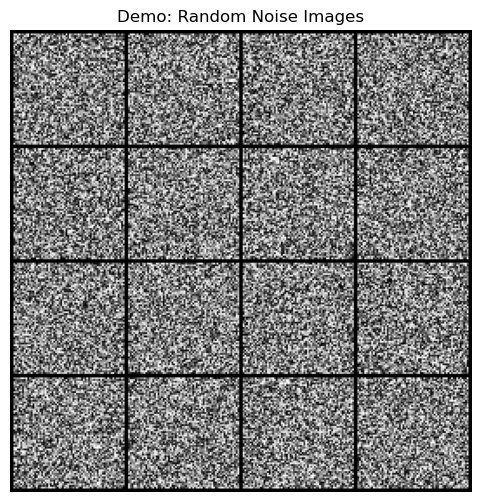

Range before: 2.205371856689453e-06 to 0.9999793171882629
Range before: -0.9999955892562866 to 0.9999586343765259


In [ ]:
def show_images_grid(tensor, nrow=8, title=None):
    """Display a batch of images arranged in a grid.

    Parameters
    ----------
    tensor : torch.Tensor
        Batch of images with shape (B, C, H, W), where:
        - B = batch size
        - C = number of channels (1 for grayscale, 3 for RGB)
        - H, W = height and width
        Pixel values are expected to be in the range [-1, 1].

    nrow : int, optional (default=8)
        Number of images per row in the grid.

    title : str, optional
        Title for the plot. If None, no title is displayed.
    """

    with torch.no_grad():
        # Normalize: [-1,1] -> [0,1]
        imgs = (tensor.clamp(-1, 1) + 1) / 2.0

        # organize the  batches of images in a grid. Note: images are moved to CPU, since matplotlib cannot handle CUDA tensors.
        grid = make_grid(imgs.cpu(), nrow=nrow)

    # PyTorch images are shaped (C, H, W) (channels first). Matplotlib expects (H, W, C) (channels last).
    # Its necessary to make the image transpose
    grid_transpose = np.transpose(grid.numpy(), (1,2,0))

    # Plot definitions
    plt.figure(figsize=(6,6))
    plt.imshow(grid_transpose)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

## ---- Test the function -----

# Create a batch of 16 random "images" with 1 channel, 64x64 pixels
# the original range is [0, 1] and we need to have [-1, 1] to mimic generator output
dummy_images = torch.rand(16, 1, 64, 64)

# Convert images range from [0, 1] → [0, 2] → [-1, 1]
dummy_images_converted = dummy_images *2 -1

# Show the grid
show_images_grid(dummy_images_converted, nrow=4, title="Demo: Random Noise Images")

print("Range before:", dummy_images.min().item(), "to", dummy_images.max().item())
print("Range before:", dummy_images_converted.min().item(), "to", dummy_images_converted.max().item())

💡 **Challenge Question:**  
Why do we normalize images to the range [-1, 1]?

**Hints:** Look to the Generator in the DCGAN architecture.  

## Create the experiment outputs folder



In [ ]:
OUT_DIR = Path("gan_outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)
print("OUT_DIR:", OUT_DIR.resolve())

OUT_DIR: C:\Users\Joao\Downloads\gan_outputs


## Dataset (MNIST)
In this notebook we will use the **MNIST dataset** as our playground.  

- **What is it?**  
  MNIST (Modified National Institute of Standards and Technology database) is a large collection of **handwritten digits** from 0 to 9.  

- **Dataset size:**  
  - 60,000 images for training  
  - 10,000 images for testing  

- **Image characteristics:**  
  - Grayscale images (1 channel)  
  - Resolution: **28 × 28 pixels**  
  - Values range: 0 (black) → 255 (white) if stored as raw images (original state).  
  - After applying `torchvision.transforms.ToTensor()`, values are normalized to `[0.0, 1.0]`.

  **Why MNIST?**  
  - It is small and lightweight, so training is fast even on CPU.  

### Download dataset as Pytorch Tensor

In [ ]:
# MNIST data presents a resolution of 28×28 pixels.
# But the DCGAN architecture expect a 64 resolution image
IMG_SIZE = 64

transform = T.Compose([
    T.Resize(IMG_SIZE), # resize to match the DCGAN architecture resolution
    T.ToTensor(), #convert PIL images (original dataset) to PyTorch tensor with values in [0,1]
    T.Normalize(mean=[0.5], std=[0.5]) #Apply normalization, converting range to [-1, 1].
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Apply a subdataset for testing purposes - remove this code when executing for real
#subset_size = 5000
# Select some randon indexes
#indices = np.random.choice(len(trainset), size=subset_size, replace=False)
# Create subset
#trainset = Subset(trainset, indices)


# Print some detals about the dataset
print("nTrain dataset size:", len(trainset))
print("Dataset files type:", type(trainset[0][0]))
print("Classes:", getattr(trainset, 'classes', 'n/a'))

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found




100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

nTrain dataset size: 5000
Dataset files type: <class 'torch.Tensor'>
Classes: n/a


### Sample from the Dataset (as Pytorch Tensor)


Dataset sample:
 - Type: <class 'torch.Tensor'>
 - Shape: torch.Size([1, 64, 64])
 - Min/Max values: -1.0 0.9843137264251709
 - Label: 7


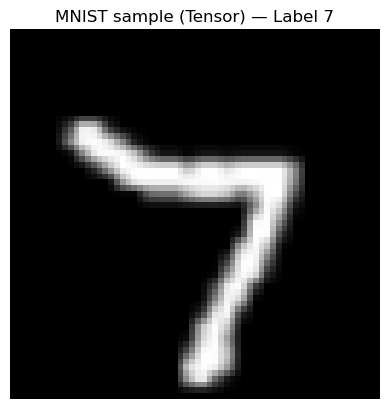

In [ ]:
# Choose a sample from the dataset
img_tensor, label_tensor = trainset[0]

# Print the sample characteristics
print("\nDataset sample:")
print(" - Type:", type(img_tensor))
print(" - Shape:", img_tensor.shape)
print(" - Min/Max values:", img_tensor.min().item(), img_tensor.max().item())
print(" - Label:", label_tensor)

# Print the sample as image (imshow)
plt.imshow(img_tensor[0], cmap="gray")
plt.title(f"MNIST sample (Tensor) — Label {label_tensor}")
plt.axis("off")
plt.show()

### Plot the image distribution of values

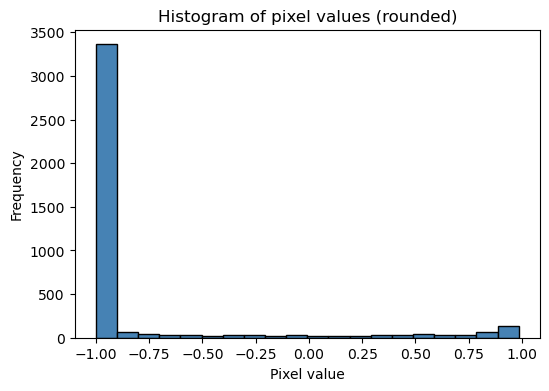

In [ ]:
# Plot histogram of pixel values
plt.figure(figsize=(6,4))
plt.hist(img_tensor.flatten(), bins=20, color="steelblue", edgecolor="black")
plt.title("Histogram of pixel values (rounded)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

### Plot the same as the tensor

In [ ]:
# Convert to numpy int for cleaner display
img_full = img_tensor.round().numpy().astype(int)

# Tell numpy not to truncate the array - Basically it allow to see all the array in the output
original_opts = np.get_printoptions()
np.set_printoptions(threshold=np.inf, linewidth=200)

print(img_full)

# Restore original options
np.set_printoptions(**original_opts)

[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1

💡 **Challenge:**  
For this notebook we’ll work with MNIST, but once you understand the workflow, try experimenting with other datasets such as Fashion-MNIST, CIFAR-10, or even your own custom images. How does the quality of the generated samples change when the dataset becomes more complex

### Create Data Loaders

In [ ]:
BATCH_SIZE = 16 # would be great to use 128, but it requires more memory
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

print("Train size:", len(trainset),)

Train size: 5000


### Quick visualization of one batch

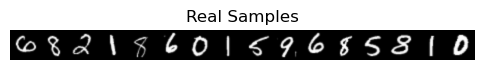

In [ ]:
#Get one batch of images from the dataloader
data_iter = iter(trainloader)
one_example_batch, _ = next(data_iter)

# Visualize the real images in a grid - Use the method we previously created
show_images_grid(one_example_batch, nrow=16, title="Real Samples")

# ---- Checkpoints - just to be sure we have the data in the right format ----
assert one_example_batch.shape[2:] == (IMG_SIZE, IMG_SIZE), "Incorrect image size!"
assert one_example_batch.min() >= -1.1 and one_example_batch.max() <= 1.1, "Expected normalization in [-1,1]."


## Deep Convolutional GAN (DCGAN)

So far, we’ve prepared the dataset and confirmed that images are normalized into the range [-1, 1].  
Now it’s time to define the two main components of a GAN:

- **Generator (G):** takes random noise `z ~ N(0,1)` as input and tries to create realistic fake images.  
- **Discriminator (D):** takes an image (real or fake) and predicts whether it is real (from dataset) or fake (from generator).  

DCGAN is a particular type of GAN that uses convolutional layers (instead of fully connected layers), which makes it much better at modeling images.




### Generator (G)

**Architecture:**
- Input: latent vector `z` of dimension `Z_DIM` (usually 100).  
- Layers: series of `ConvTranspose2d` (also called *deconvolutions*) that upsample the noise into a 64×64 image.  
- Activation functions: `ReLU` for hidden layers, and `Tanh` for the final output (so images are in [-1, 1]).  

Key idea: start from a random vector and progressively build up spatial resolution until reaching an image.


In [ ]:
Z_DIM = 100      # size of latent vector z
G_CHANNELS = 64  # base feature map size in Generator
NC = 1           # number of image channels (1 = grayscale, 3 = RGB)

class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM, gch=G_CHANNELS, out_c=NC):
        super().__init__()
        self.net = nn.Sequential(

            # Layer 1
            nn.ConvTranspose2d(
                in_channels=z_dim,        # latent vector size (100)
                out_channels=gch*8,       # 512 feature maps
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(gch*8),
            nn.ReLU(True),

            # Layer 2
            nn.ConvTranspose2d(in_channels=gch*8, out_channels=gch*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gch*4),
            nn.ReLU(True),

            # Layer 3:
            nn.ConvTranspose2d(in_channels=gch*4, out_channels=gch*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gch*2),
            nn.ReLU(True),

            # Layer 4:
            nn.ConvTranspose2d(in_channels=gch*2, out_channels=gch, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gch),
            nn.ReLU(True),

            # Layer 5 (final)
            nn.ConvTranspose2d(in_channels=gch, out_channels=out_c, kernel_size=4, stride=2, padding=1, bias=False),
            # output in [-1, 1]
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

G = Generator().to(device)

print(G)


Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#### Summary Growth Path
```
(B, 100, 1, 1)  →  (B, 512, 4, 4)
                 →  (B, 256, 8, 8)
                 →  (B, 128, 16, 16)
                 →  (B, 64, 32, 32)
                 →  (B, 1, 64, 64)
```
- Start with a noise vector (100 × 1 × 1)
- Upsample step by step
- End with a 64×64 fake image.

### Discriminator (D)

**Architecture:**
- Input: image of size 64×64.  
- Layers: series of `Conv2d` layers with stride=2 (downsampling).  
- Activation functions: `LeakyReLU` for hidden layers, and `Sigmoid` at the output (a probability between 0 and 1).  

Key idea: progressively compress the image into a single probability (real vs fake).

In [ ]:
D_CHANNELS = 64  # base feature map size in Discriminator

class Discriminator(nn.Module):
    def __init__(self, dch=D_CHANNELS, in_c=NC):
        super().__init__()
        self.net = nn.Sequential(

            # Layer 1
            nn.Conv2d(
                in_channels=in_c,     # number of channels in input image (1 = grayscale)
                out_channels=dch,     # 64 feature maps
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 2
            nn.Conv2d(in_channels=dch, out_channels=dch*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dch*2),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3
            nn.Conv2d(in_channels=dch*2, out_channels=dch*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dch*4),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4
            nn.Conv2d(in_channels=dch*4, out_channels=dch*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dch*8),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 5 (final)
            nn.Conv2d(in_channels=dch*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            # output: probability in [0, 1]
            nn.Sigmoid()
        )

    def forward(self, x):
        # Flatten to (batch_size, 1) for binary classification (real/fake)
        return self.net(x).view(x.size(0), -1)


D = Discriminator().to(device)

print(D)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### Weight Initialization
GAN training is very sensitive to initialization.  
The DCGAN paper recommends initializing weights with:
- Normal distribution with mean = 0 and std = 0.02 for convolutional layers.  
- Normal distribution with mean = 1 and std = 0.02 for BatchNorm weights, and bias = 0.  
This helps stabilize training and prevents early collapse.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # Conv layers → weights initialized with N(0, 0.02
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # BatchNorm weights: Normal(1, 0.02)
        nn.init.constant_(m.bias.data, 0) # BatchNorm bias: 0


G.apply(weights_init)
D.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

### Loss functions and optimizers

Now that we have defined **G** and **D**, we need:
1. A **loss function** to measure how well G and D are doing.
2. **Optimizers** to update their weights.



We use **Binary Cross-Entropy (BCE)** because:
- The Discriminator is a binary classifier (real vs fake).
- The Generator wants to *fool* the Discriminator.

⚠️ In practice, instead of the original minimax formulation, we use the **non-saturating loss** for the Generator:
- Original GAN loss can lead to vanishing gradients (bad learning).
- Non-saturating loss flips the sign so that the Generator *maximizes* log(D(G(z))).
- This trick makes training much more stable (introduced in Goodfellow’s GAN paper).


In [ ]:
# Binary Cross Entropy (BCE)
bce = nn.BCELoss()

# Learning rate: 0.0002 (stable, but not too slow)
lr = 2e-4

# Bettas according the receipt we have discussed in the class
beta1 = 0.5
beta2 =  0.999

# define the optimers
optD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
optG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

### Fixed noise for monitoring training outputs
During training we want to see how the Generator improves.  
We define a *fixed set of latent vectors* `fixed_z`, sampled once, that we will use to generate samples after each epoch.
This allows us to directly compare outputs across training.


In [ ]:
# Create a fixed batch of latent vectors (noise)
fixed_z = torch.randn(
    size=(64, Z_DIM, 1, 1),  # (batch_size, latent_dim, height, width)
    device=device            # ensure it’s created on the right device (CPU/GPU)
)

# Take the first latent vector from fixed_z - Just to have an idea about what was created.
z_example = fixed_z[0].view(-1).cpu().numpy()

# Print details about this single latent vector
print("Shape of one latent vector:", z_example.shape)
print("First 10 values:\n", z_example[:10])  # preview only first 10

Shape of one latent vector: (100,)
First 10 values:
 [ 1.2009069  -1.467081    0.43403143  1.4069808  -2.07404     2.1029153
 -1.4194661  -1.958186   -0.11812129 -0.06445692]


### Adversarial Training (DCGAN)

Now that we have defined the **Generator (G)** and the **Discriminator (D)**, we can set up the **adversarial training loop**.  
The training process is a **two-player game**:

#### Iteration steps
For each mini-batch:
1. **Update D**  
   - Train with a batch of real images (label = 1).  
   - Train with a batch of fake images produced by G (label = 0).  
   - Loss = `loss_real + loss_fake`.  

2. **Update G**  
   - Generate a new batch of fake images.  
   - Ask D to classify them.  
   - Instead of target = 0, we flip it to **1** so G is rewarded when D thinks fakes are real.  
   - Loss = `BCE(D(G(z)), 1)` (non-saturating trick).  

---

⚡ **Training tips:**  
- On **CPU**, use fewer epochs (2–5) to keep runtime reasonable.  
- On **GPU**, you can run for longer (10–25 epochs) for much higher quality results.  

---

💡 By the end of training, you should see the generated samples (using the fixed noise `fixed_z`) gradually evolve from random noise into digits that look like MNIST.


#### Training Setup

In [ ]:
EPOCHS = 10 # try with 3 or more
k_steps_D = 1 # how many times to update D per G update

# Set models to training mode
# Important: this only sets BatchNorm/Dropout to training mode.
# (It does NOT start training yet — that's done in the loop below)
G.train()
D.train()

# Store loss history for plotting later
loss_hist = {"G": [], "D": []}

# Used to track the adversarial training time
start_time = time.time()

#### Training loop

Epoch [1/10] Step [100/313]  D: 0.022  G: 33.630
Epoch [1/10] Step [200/313]  D: 0.087  G: 3.889
Epoch [1/10] Step [300/313]  D: 0.207  G: 4.513


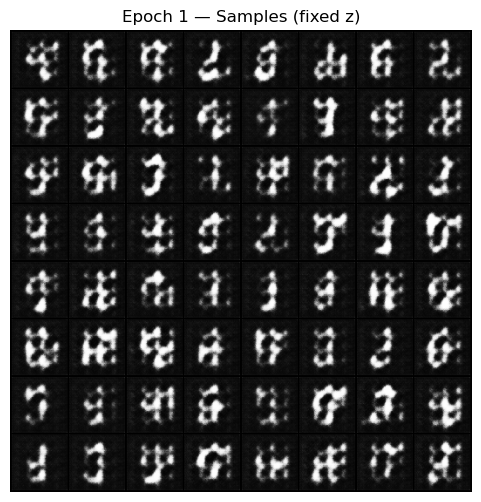

Epoch [2/10] Step [100/313]  D: 0.460  G: 5.364
Epoch [2/10] Step [200/313]  D: 0.835  G: 2.486
Epoch [2/10] Step [300/313]  D: 0.333  G: 2.080


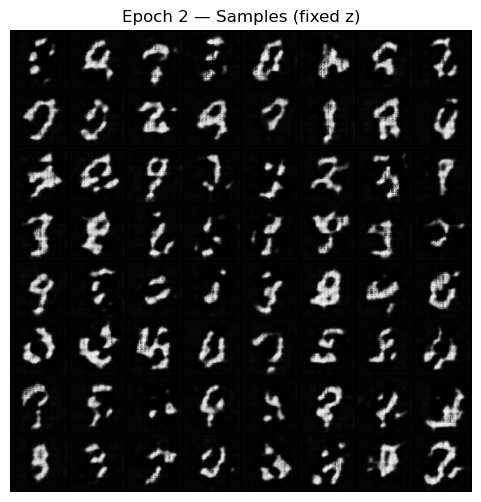

Epoch [3/10] Step [100/313]  D: 0.956  G: 9.110
Epoch [3/10] Step [200/313]  D: 0.639  G: 1.941
Epoch [3/10] Step [300/313]  D: 0.502  G: 4.183


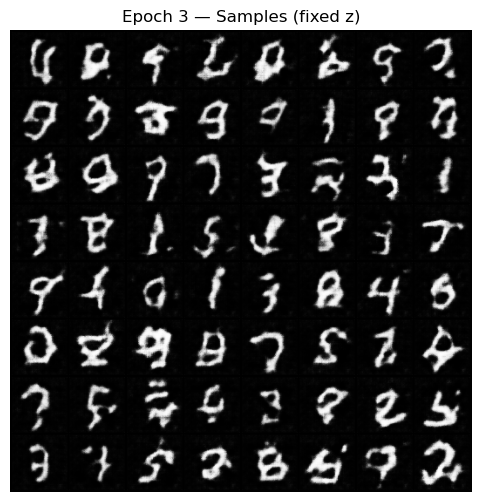

Epoch [4/10] Step [100/313]  D: 1.729  G: 0.659
Epoch [4/10] Step [200/313]  D: 0.946  G: 1.031
Epoch [4/10] Step [300/313]  D: 1.631  G: 1.001


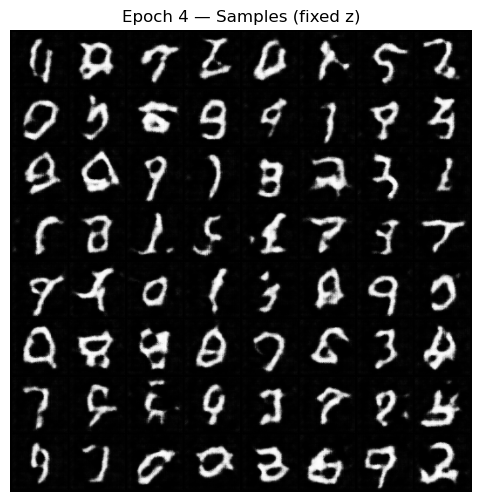

Epoch [5/10] Step [100/313]  D: 0.250  G: 2.394
Epoch [5/10] Step [200/313]  D: 0.089  G: 3.996
Epoch [5/10] Step [300/313]  D: 1.159  G: 0.393


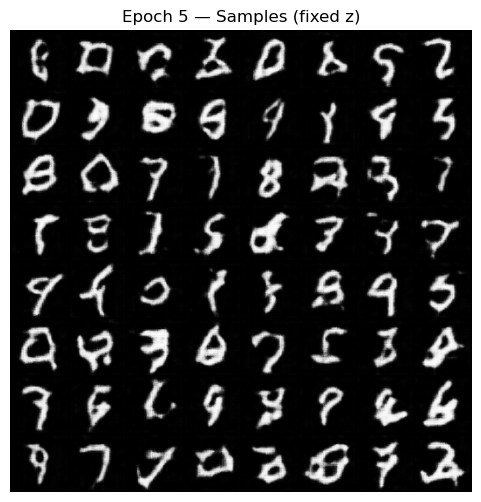

Epoch [6/10] Step [100/313]  D: 0.319  G: 1.863
Epoch [6/10] Step [200/313]  D: 0.158  G: 6.410
Epoch [6/10] Step [300/313]  D: 1.387  G: 5.714


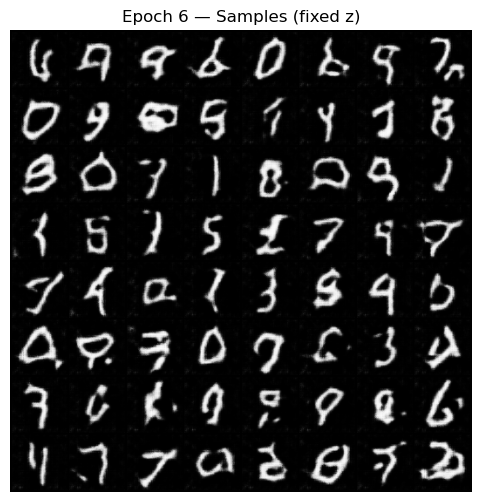

Epoch [7/10] Step [100/313]  D: 0.130  G: 2.130
Epoch [7/10] Step [200/313]  D: 0.281  G: 4.100
Epoch [7/10] Step [300/313]  D: 0.192  G: 4.194


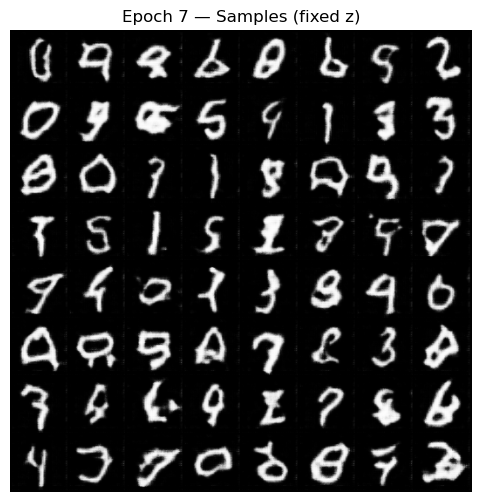

Epoch [8/10] Step [100/313]  D: 1.576  G: 1.134
Epoch [8/10] Step [200/313]  D: 0.066  G: 5.139
Epoch [8/10] Step [300/313]  D: 0.837  G: 1.900


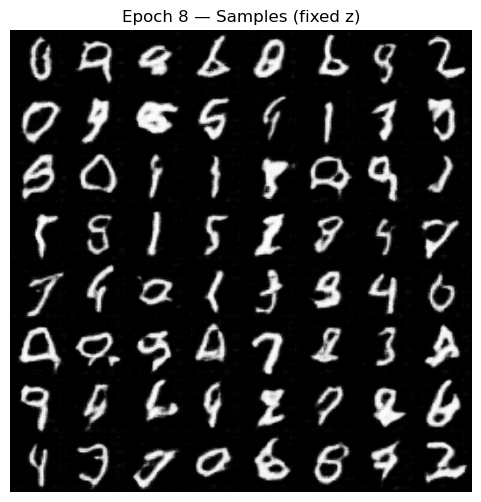

Epoch [9/10] Step [100/313]  D: 0.087  G: 4.940
Epoch [9/10] Step [200/313]  D: 0.612  G: 1.056
Epoch [9/10] Step [300/313]  D: 0.255  G: 7.981


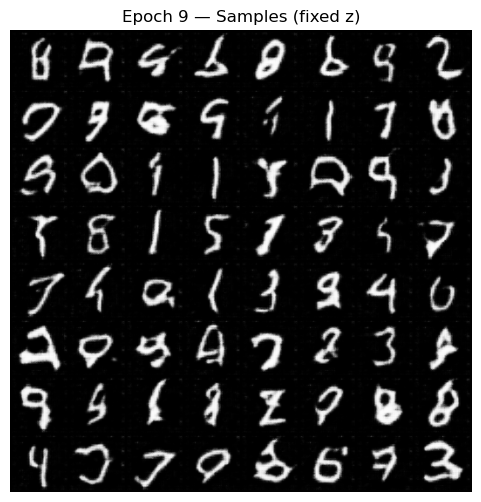

Epoch [10/10] Step [100/313]  D: 0.089  G: 2.384
Epoch [10/10] Step [200/313]  D: 0.035  G: 8.119
Epoch [10/10] Step [300/313]  D: 0.215  G: 4.561


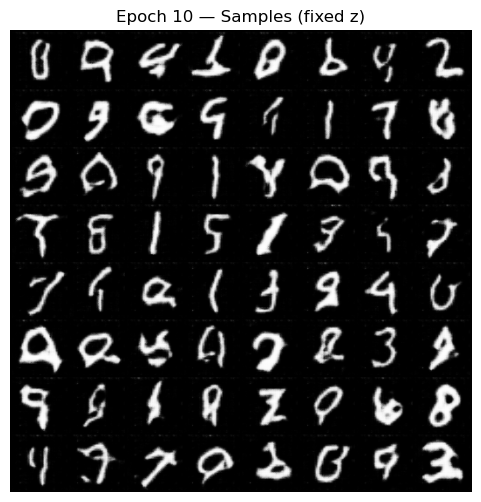

Training finished in 57.5 min


In [ ]:
for epoch in range(1, EPOCHS+1):
    for i, (x, _) in enumerate(trainloader): # NOTE: We ignore dataset labels, since GANs are unsupervised.
        x = x.to(device)  # real images
        bs = x.size(0)    # batch size for this iteration (may be smaller at the end)

        # Define real and fake labels
        real_lbl = torch.ones(bs, 1, device=device) # real = 1
        fake_lbl = torch.zeros(bs, 1, device=device) # fake = 0

        # ---- Train Discriminator ----
        for _ in range(k_steps_D): # D can be trained multiple steps per G update

            # clear old gradients before backprop
            D.zero_grad(set_to_none=True)

            # ---- Step 1a: D on real images ----
            out_real = D(x) # D’s prediction on real images
            # Compare the labels predicts by the Discriminator with the real labels
            loss_real = bce(out_real, real_lbl) # as in this case we're submmiting the original/real images, the labels are always 1

            # ---- Step 1b: D on fake images ----
            z = torch.randn(size=(bs, Z_DIM, 1, 1), device=device) # generate the random noise vectors
            fake = G(z).detach() # Generating the fake images from the noise batch # detach so G is not updated here

            # Forward Descriminator on fake images
            out_fake = D(fake)
            loss_fake = bce(out_fake, fake_lbl) # as in this case we're submmiting the fakes images, the labels are always 0

            # ---- Step 1c: Total D loss ----
            loss_D = loss_real + loss_fake # Total loss for Discriminator: must classify real as 1 and fake as 0
            loss_D.backward() # Backpropagate: compute gradients for all parameters in D
            optD.step() # Update Discriminator’s weights using the optimizer

        # ---- Train Generator (non-saturating) ----
        G.zero_grad(set_to_none=True) # clear old gradients before backprop

        # ---- Step 2a: Generate fake images ----
        z = torch.randn(size=(bs, Z_DIM, 1, 1), device=device) # generate the random noise vectors
        fake = G(z) # generate fake images

        # ---- Step 2b: Pass fakes through D ----
        out = D(fake) # classify generated fake images with Descriminator

        # ---- Step 2c: Generator loss ----
        # Calculate G loss and update the weights
        loss_G = bce(out, real_lbl) # IMPORTANT. In there we are using the real_lbl (1) instead of fake_lbl (0). The non-saturating trick!
        loss_G.backward()
        optG.step()

        # Logging every 100 epochs the models losses
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}] Step [{i+1}/{len(trainloader)}]  D: {loss_D.item():.3f}  G: {loss_G.item():.3f}")

    # Generate fixed samples to track progress over epochs, from the defined fixed noise
    G.eval() # set the G in evaluation mode
    with torch.no_grad():
        fake_fixed = G(fixed_z).cpu()
    # Presents the images generated from the Generator from the defined fixed noise
    show_images_grid(fake_fixed, nrow=8, title=f"Epoch {epoch} — Samples (fixed z)")
    G.train()  # switch back to training mode

    # Save the final loss values from this epoch
    loss_hist['D'].append(loss_D.item())
    loss_hist['G'].append(loss_G.item())

# Control the adversarial training time
elapsed = time.time() - start_time
print(f"Training finished in {elapsed/60:.1f} min")


#### Loss Evolution

Monitoring the losses of the **Discriminator (D)** and **Generator (G)** helps us understand the training dynamics.  

⚠️ **Important notes:**
- GAN losses are **not reliable absolute metrics** — a lower loss does not always mean better images.  
- Instead, use them as a *rough guide* to check for divergence or collapse.  
- Always **inspect the generated samples** (`fixed_z`) to truly evaluate progress.



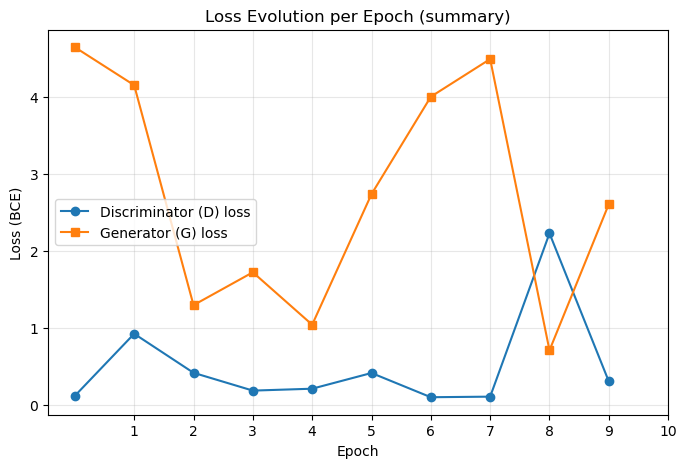

In [ ]:
# Plot the evolution of Discriminator and Generator losses
plt.figure(figsize=(8,5))

plt.plot(loss_hist["D"], label="Discriminator (D) loss", marker="o")
plt.plot(loss_hist["G"], label="Generator (G) loss", marker="s")

plt.xlabel("Epoch")
plt.ylabel("Loss (BCE)")
plt.title("Loss Evolution per Epoch (summary)")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(1, len(loss_hist["D"])+1))  # show epoch ticks explicitly

plt.show()


### Proposed exercises 1

#### Exercise 1 — Non-saturating vs Minimax

Task: change the G loss to the original saturating form and observe learning.

**Tips**:
- The original objective minimizes log(1 - D(G(z))).
- Instead of target=1 in BCE, use target=0 on D(G(z)).

#### Exercise 2 — Game balance (k-steps)
Task: adjust k_steps_D to 2 or 3. Observe if G improves or if D dominates.

**Tips**
- If G is weak, more D steps can help initially.
- If D dominates, reduce k_steps_D.

## WGAN-GP — Wasserstein GAN with Gradient Penalty

The **Wasserstein GAN (WGAN)** was introduced to address stability issues in training GANs.  
Instead of predicting probabilities with a Sigmoid, the Discriminator is replaced by a **Critic** that outputs real-valued scores.  

- **Generator (G):** takes random noise `z ~ N(0,1)` and generates fake images.  
- **Critic (C):** takes an image (real or fake) and outputs a *score* (higher = more real, lower = more fake).  

The training objective becomes the **Wasserstein distance** between the real and generated distributions.

⚠️ To ensure the Critic is 1-Lipschitz (a key mathematical requirement), the improved version **WGAN-GP** adds a **Gradient Penalty**:
- Penalizes gradients of the Critic that deviate from 1 on interpolations between real and fake samples.
- This stabilizes training much more effectively than the original weight clipping trick

<br> **Key differences vs DCGAN:**
- **No Sigmoid** in the Critic’s output (raw scores, not probabilities).  
- **Losses**:  
  - Critic: `loss_D = -(mean(C(real)) - mean(C(fake))) + λ * GP`  
  - Generator: `loss_G = -mean(C(fake))`  
- **Optimizers**: Adam with betas `(0.0, 0.9)` is commonly used.  
- **Training schedule**: The Critic is often updated multiple times (e.g., 5) per Generator update.  

WGAN-GP provides **much more stable training** and generates higher quality samples compared to vanilla DCGAN.

### Critic (C) — for WGAN / WGAN-GP

**Architecture:**
- Input: image of size 64×64.  
- Layers: series of `Conv2d` layers with stride=2 (downsampling).  
- Activation: `LeakyReLU` for hidden layers.  
- **No Sigmoid at the output**: the Critic produces **raw scores** instead of probabilities.  

Key idea: instead of classifying images as *real/fake*,  
the Critic learns to **assign higher scores to real images and lower scores to fake ones**.  
The Wasserstein loss then pushes the gap `D(real) − D(fake)` to be as large as possible.

In [ ]:
D_CHANNELS = 64  # base feature map size in Critic

class Critic(nn.Module):
    def __init__(self, dch=D_CHANNELS, in_c=NC):
        super().__init__()
        self.net = nn.Sequential(

            # Layer 1
            nn.Conv2d(
                in_channels=in_c,     # number of channels in input image (1 = grayscale)
                out_channels=dch,     # 64 feature maps
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 2
            nn.Conv2d(in_channels=dch, out_channels=dch*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dch*2),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3
            nn.Conv2d(in_channels=dch*2, out_channels=dch*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dch*4),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4
            nn.Conv2d(in_channels=dch*4, out_channels=dch*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(dch*8),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 5 (final)
            nn.Conv2d(in_channels=dch*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)
            # NOTE: no Sigmoid → output is a real-valued score
        )

    def forward(self, x):
        # Flatten to (batch_size, 1) → each image gets one real-valued score
        return self.net(x).view(x.size(0), -1)


C = Critic().to(device)
print(C)

Critic(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


---

### Discriminator vs Critic

| Model                  | Output                     | Interpretation                   | Loss Function      |
|------------------------|----------------------------|----------------------------------|-------------------|
| **Discriminator (DCGAN)** | Probability in **[0, 1]**   | Classifies image as *real* (1) or *fake* (0) | **Binary Cross-Entropy (BCE)** |
| **Critic (WGAN / WGAN-GP)** | Real number in **ℝ** (unbounded) | Higher score = more real, lower score = more fake | **Wasserstein loss** (`D(real) - D(fake)`) |

**Key difference:**  
- The **Discriminator** is a *binary classifier*.  
- The **Critic** is a *score function*: it learns to assign higher values to real samples and lower values to fake ones.  
The training objective (Wasserstein loss with Gradient Penalty) ensures this difference is meaningful and stable.

### Gradient Penalty (GP)

In the original WGAN paper, the Critic was forced to be **1-Lipschitz** by *weight clipping* (restricting weights to a fixed range).  
However, this often led to poor convergence and unstable training.  

The improved version, **WGAN-GP**, replaces weight clipping with a **Gradient Penalty (GP)**:  
- The idea is that the gradient norm of the Critic with respect to its input should be **close to 1**.  
- If the gradient norm deviates from 1, we add a penalty to the Critic’s loss.  

<br> **Why it matters:**  
- Enforces the Lipschitz constraint in a softer, more stable way than clipping.  
- Prevents exploding/vanishing gradients in the Critic.  
- Leads to much more **stable training** and higher quality generated samples.  


In [ ]:
def gradient_penalty(critic, real, fake, device="cpu", lambda_gp=10.0):
    """
    Compute the Gradient Penalty (GP) term used in WGAN-GP.

    The GP enforces the 1-Lipschitz constraint on the Critic by penalizing
    deviations of the gradient norm from 1. It is computed on random
    interpolations between real and fake images.

    Parameters
    ----------
    critic : nn.Module
        The Critic network
    real : torch.Tensor
        Batch of real images with shape (B, C, H, W).
    fake : torch.Tensor
        Batch of generated (fake) images with shape (B, C, H, W).
    device : str or torch.device
        Device where tensors are located (e.g., "cpu" or "cuda").
    lambda_gp : float, optional (default=10.0)
        Weight of the gradient penalty term.

    Returns
    -------
    gp : torch.Tensor (scalar)
        The gradient penalty value to be added to the Critic loss.
    """

    batch_size = real.size(0)

    # Step 1: Sample random interpolation coefficients α ~ U(0,1)
    alpha = torch.rand(size=(batch_size, 1, 1, 1), device=device)

    # Step 2: Interpolate between real and fake images
    interpolates = alpha * real + (1 - alpha) * fake
    interpolates.requires_grad_(True)  # enable gradient computation

    # Step 3: Compute Critic scores on the interpolated images
    critic_scores = critic(interpolates)

    # Step 4: Compute gradients of Critic outputs w.r.t. interpolated images
    gradients = torch.autograd.grad(
        outputs=critic_scores,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]  # [0] extracts the gradients tensor

    # Step 5: Flatten gradients per sample and compute their L2 norm
    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, dim=1)

    # Step 6: Compute the penalty: (||grad||2 - 1)^2
    gp = lambda_gp * ((grad_norm - 1) ** 2).mean()

    return gp


### WGAN-GP Losses

In the Wasserstein GAN with Gradient Penalty (WGAN-GP), the objective is different from the original GAN:

- **Critic (formerly the discriminator)**:  
  Instead of predicting probabilities of "real vs fake", the critic outputs a **real-valued score**.  
  The goal is to assign higher scores to real images and lower scores to fake images.  
  The Wasserstein loss encourages a large margin between the critic’s evaluation of real vs fake samples.

- **Generator**:  
  The generator tries to produce fake images that receive **high critic scores**, effectively minimizing the critic’s ability to distinguish real from fake.

- **Gradient Penalty (GP)**:  
  A key addition to WGAN-GP is the gradient penalty term, which enforces the Lipschitz constraint (the critic’s gradients must have norm ≈ 1).  
  This stabilizes training and avoids issues of weight clipping used in the original WGAN.

Mathematically:
- Critic loss ≈ *(fake_score – real_score) + λ·GP*  
- Generator loss ≈ *– fake_score*

Below we define these loss functions in PyTorch:


In [ ]:
def critic_loss_wgangp(critic, real_imgs, fake_imgs, device, lambda_gp=10.0):
    # Critic scores
    c_real = critic(real_imgs)
    c_fake = critic(fake_imgs.detach())  # detach so G isn't updated here

    # Wasserstein critic objective (maximize c_real - c_fake) -> minimize (c_fake - c_real)
    wasserstein = (c_fake - c_real).mean()

    gp = gradient_penalty(critic, real_imgs, fake_imgs, device, lambda_gp=lambda_gp)
    return wasserstein + gp

def generator_loss_wgangp(critic, fake_imgs):
    # Maximize critic(fake) -> minimize -critic(fake)
    return -critic(fake_imgs).mean()


### Weight Initialization

In [ ]:
# We will create a new Generator
G = Generator().to(device)

# apply weight initialization to both networks
G.apply(weights_init)
C.apply(weights_init)

Critic(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

### Define Optimizers

In [ ]:
# WGAN-GP recommended values
lr = 1e-4
beta1, beta2 = 0.0, 0.9

# define the optimers
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
opt_C = torch.optim.Adam(C.parameters(), lr=lr, betas=(beta1, beta2))

### Adversarial Training (WGAN-GP)

Now we bring all the components together to train the WGAN-GP:

- **Training dynamics**:
  - For each batch, the **critic** is updated multiple times (e.g. 5 steps) before the generator is updated once.
  - The critic tries to maximize the difference between its scores on real and fake images (Wasserstein estimate).
  - The generator tries to produce images that receive higher scores from the critic.

- **Gradient Penalty**:
  - Added to the critic loss to enforce the 1-Lipschitz constraint.
  - Keeps training stable and prevents critic collapse or exploding gradients.

- **Optimizers**:
  - We use Adam with learning rate `1e-4` and betas `(0.0, 0.9)`, as recommended for WGAN-GP.

- **Training loop**:
  1. Sample a batch of real images.
  2. Generate fake images from random latent vectors `z`.
  3. Update the critic loss = (c_fake − c_real) + λ·GP.
  4. Every `n_critic` steps, update the generator loss = −c_fake.
  5. Periodically visualize generated samples to monitor progress.


#### Training Setup

In [ ]:
EPOCHS = 10 # try with 3 or more
k_steps_C = 1 # how many times to update C per G update. According with the original papel should be 5
lambda_gp = 10  # gradient penalty weight

# Set models to training mode
# Important: this only sets BatchNorm/Dropout to training mode.
# (It does NOT start training yet — that's done in the loop below)
G.train()
C.train()

# Store loss history for plotting later
loss_hist = {"G": [], "C": []}

# Used to track the adversarial training time
start_time = time.time()

#### Training loop

Epoch [1/10] Step [100/313]  C: -39.080  G: 3.535
Epoch [1/10] Step [200/313]  C: -62.986  G: 5.449
Epoch [1/10] Step [300/313]  C: -46.182  G: 5.365


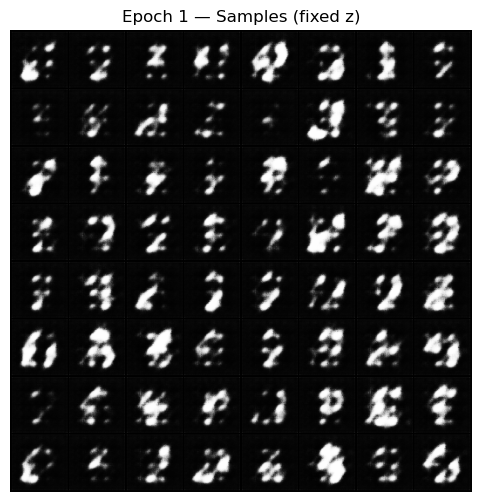

Epoch [2/10] Step [100/313]  C: -84.857  G: 10.306
Epoch [2/10] Step [200/313]  C: 74.462  G: 46.696
Epoch [2/10] Step [300/313]  C: -117.296  G: 54.312


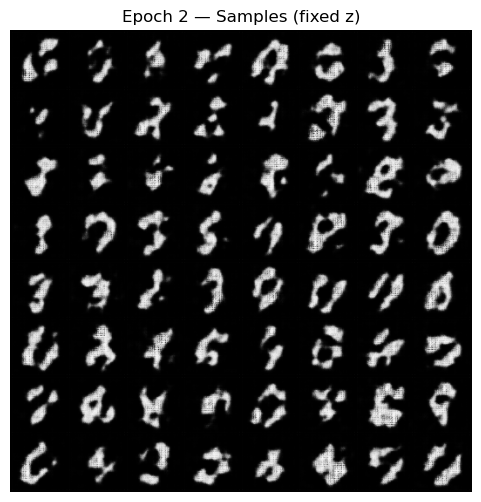

Epoch [3/10] Step [100/313]  C: -145.354  G: 43.701
Epoch [3/10] Step [200/313]  C: -151.089  G: 83.913
Epoch [3/10] Step [300/313]  C: -229.198  G: 75.860


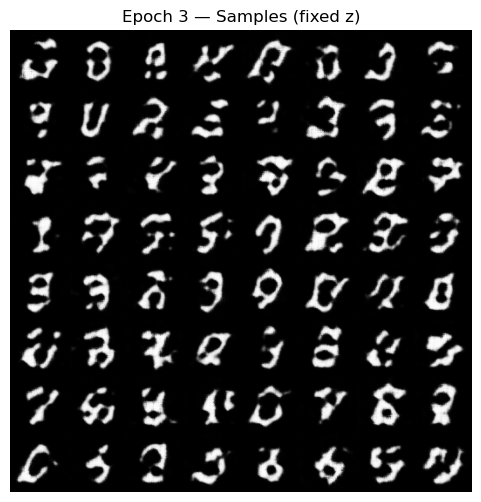

Epoch [4/10] Step [100/313]  C: -215.435  G: 86.880
Epoch [4/10] Step [200/313]  C: -257.224  G: 2.850
Epoch [4/10] Step [300/313]  C: -185.366  G: 147.001


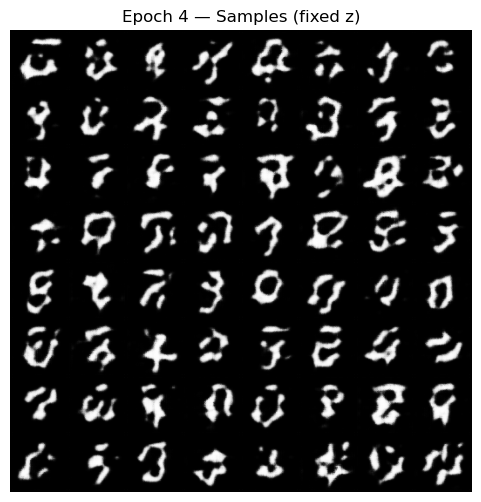

Epoch [5/10] Step [100/313]  C: -295.982  G: 148.964
Epoch [5/10] Step [200/313]  C: -297.129  G: 229.262
Epoch [5/10] Step [300/313]  C: -457.901  G: 133.570


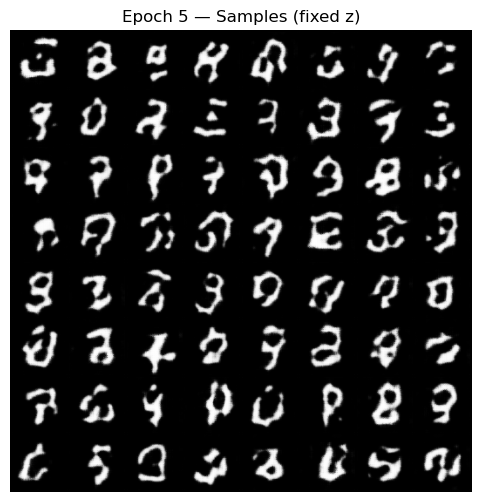

Epoch [6/10] Step [100/313]  C: -472.332  G: 197.431
Epoch [6/10] Step [200/313]  C: -483.256  G: 123.102
Epoch [6/10] Step [300/313]  C: -894.047  G: 306.957


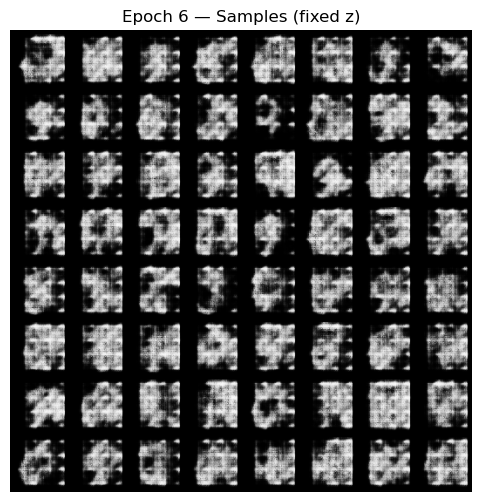

Epoch [7/10] Step [100/313]  C: -1109.787  G: 465.368
Epoch [7/10] Step [200/313]  C: -950.888  G: 486.205
Epoch [7/10] Step [300/313]  C: -996.961  G: 517.891


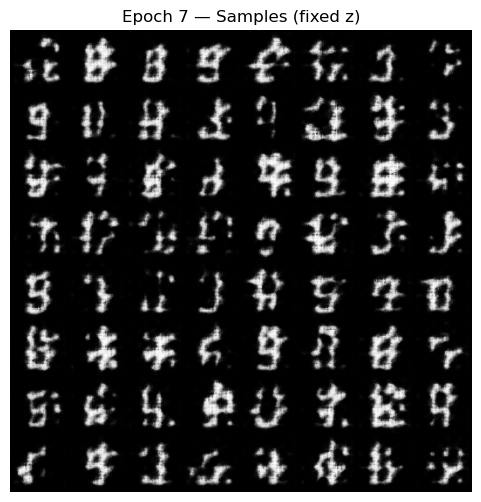

Epoch [8/10] Step [100/313]  C: -941.245  G: 467.083
Epoch [8/10] Step [200/313]  C: -832.176  G: 617.191
Epoch [8/10] Step [300/313]  C: -802.787  G: 392.602


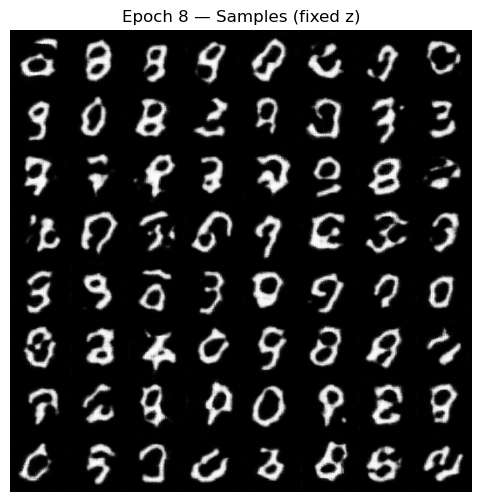

Epoch [9/10] Step [100/313]  C: -1073.175  G: 283.827
Epoch [9/10] Step [200/313]  C: -1042.568  G: 605.802
Epoch [9/10] Step [300/313]  C: -1302.914  G: 469.952


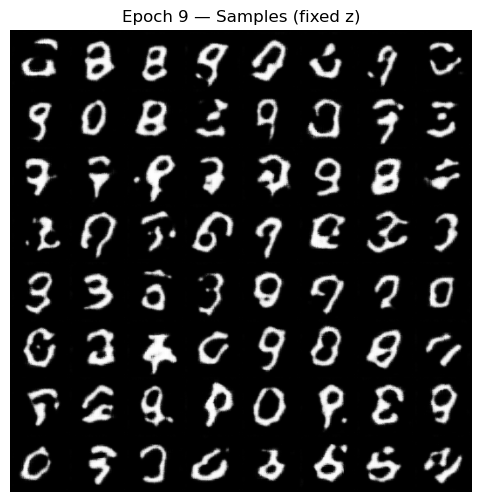

Epoch [10/10] Step [100/313]  C: -1195.644  G: 731.010
Epoch [10/10] Step [200/313]  C: -1450.766  G: 462.605
Epoch [10/10] Step [300/313]  C: -1632.689  G: 697.307


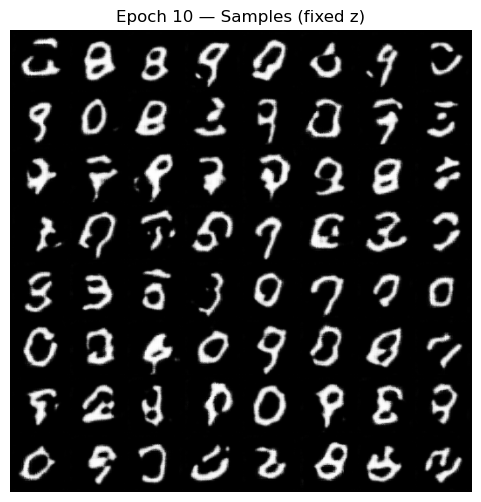

Training finished in 69.9 min


In [ ]:
for epoch in range(1, EPOCHS+1):
    for i, (x, _) in enumerate(trainloader): # NOTE: We ignore dataset labels, since GANs are unsupervised.
        x = x.to(device)  # real images
        bs = x.size(0)    # batch size for this iteration (may be smaller at the end)

        # Define real and fake labels
        ## real_lbl = torch.ones(bs, 1, device=device) # real = 1
        ## fake_lbl = torch.zeros(bs, 1, device=device) # fake = 0

        # ---- Train Critic ----
        for _ in range(k_steps_C):  # C can be updated multiple times per G update

            C.zero_grad(set_to_none=True)  # clear old gradients

            # ---- Step 1a: Generate fake images ----
            z = torch.randn(size=(bs, Z_DIM, 1, 1), device=device)  # random noise
            fake = G(z).detach()  # generate fake images (detach so G is not updated here)

             # ---- Step 1b: Critic loss with Gradient Penalty ----
            loss_C = critic_loss_wgangp(C, x, fake, device, lambda_gp=lambda_gp)

            # ---- Step 1c: Backprop + update Critic ----
            loss_C.backward()
            opt_C.step()

        # ---- Train Generator ----
        G.zero_grad(set_to_none=True)  # clear old gradients

        # ---- Step 2a: Generate fake images ----
        z = torch.randn(size=(bs, Z_DIM, 1, 1), device=device) # random noise
        fake = G(z) # generate fake images

        # ---- Step 2b: Generator loss ----
        loss_G = generator_loss_wgangp(C, fake)

        # ---- Step 2c: Backprop + update Generator ----
        loss_G.backward()
        opt_G.step()

        # Logging every 100 epochs the models losses
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}] Step [{i+1}/{len(trainloader)}]  C: {loss_C.item():.3f}  G: {loss_G.item():.3f}")

    # ---- Fixed samples to track progress ----
    G.eval()
    with torch.no_grad():
        fake_fixed = G(fixed_z).cpu()
    # Presents the images generated from the Generator from the defined fixed noise
    show_images_grid(fake_fixed, nrow=8, title=f"Epoch {epoch} — Samples (fixed z)")
    G.train()

    # Save the final loss values from this epoch
    loss_hist['C'].append(loss_C.item())
    loss_hist['G'].append(loss_G.item())

# Control the adversarial training time
elapsed = time.time() - start_time
print(f"Training finished in {elapsed/60:.1f} min")

#### Loss Evolution

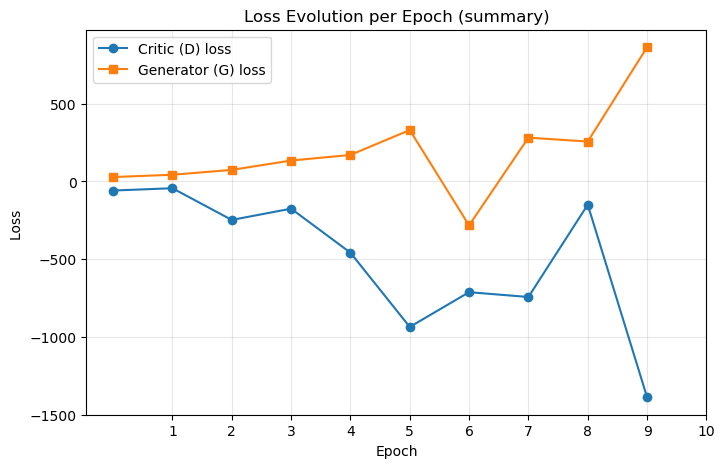

In [ ]:
# Plot the evolution of Critic and Generator losses
plt.figure(figsize=(8,5))

plt.plot(loss_hist["C"], label="Critic (D) loss", marker="o")
plt.plot(loss_hist["G"], label="Generator (G) loss", marker="s")

plt.xlabel("Epoch")
plt.ylabel("Loss ")
plt.title("Loss Evolution per Epoch (summary)")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(1, len(loss_hist["C"])+1))  # show epoch ticks explicitly

plt.show()


### Proposed exercises 2

#### Exercise 1 — Effect of the Gradient Penalty

**Task:** change the gradient penalty coefficient `lambda_gp`. Try values like `0` (disable GP), `1`, `10` (default), and `100`.

**Tips:**
- With `0`, the critic is unconstrained → expect instability or exploding critic scores.  
- With very high `lambda_gp`, training slows down or the critic becomes too restricted.  
- Observe generated samples and critic loss behavior.

#### Exercise 2 — Critic update frequency (`k_steps_C`)

**Task:** vary the number of critic updates per generator update (e.g. `k_steps_C = 1, 5, 10`).  

**Tips:**
- More critic steps (e.g. 5) give better approximations of the Wasserstein distance.  
- Too many critic steps can slow training or cause the generator to lag behind.  
- Compare image quality and convergence speed.  

#### Exercise 3 — Generator stability

**Task:** try replacing BatchNorm in the generator with LayerNorm or removing normalization. Observe if training still converges.

**Tips:**
- WGAN-GP is more stable than vanilla GAN, but normalization in G can still matter.  
- Compare sample diversity and check for mode collapse.  

#### Exercise 4 — Compare to DCGAN

**Task:** train both DCGAN (with BCE loss) and WGAN-GP under the same setup (dataset, epochs, batch size).

**Tips:**
- Look at generated samples side-by-side after the same number of epochs.  
- Discuss which model is more stable, and how the losses behave differently.  